In [59]:
import geopandas as gpd
import shapely
from matplotlib import pyplot as plt
import numpy as np

In [60]:
mask = gpd.read_file(r"data\Part_Dieu_buffer_1km.shp").to_crs(epsg=2154)
voies = gpd.read_file(r"data\voirie_mask.shp", mask=mask).to_crs(epsg=2154)


C:\Users\theot\Miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


On commence par importer les voies et le masque de la zone à traiter

<AxesSubplot:>

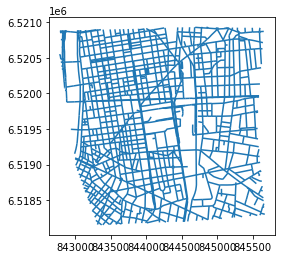

In [61]:
voies.plot()

In [62]:
bat = gpd.read_file(r"data\bat.shp", mask=mask).to_crs(epsg=2154)
arbres = gpd.read_file('data/arbres_alignement_mask.shp', mask=mask).to_crs(epsg=2154)

C:\Users\theot\Miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

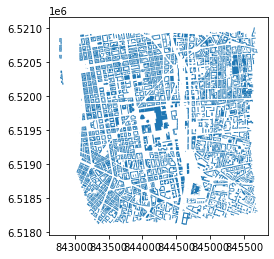

In [63]:
bat.plot()

Les couches des batiments et des arbres nous intéressent aussi (elles ont déjà été traitées pour la zone en question)

On va ensuite définir nos capteur commes les points tous les 10 mètres le long de la couche voirie

In [64]:
from t4gpd.morph.STDensifier import STDensifier
from t4gpd.morph.STGrid import STGrid

## sensors = STGrid(bat, dx=15, dy=None, indoor=False, intoPoint=True).run()
sensors = STDensifier(voies, distance=10, adjustableDist=False, removeDuplicate=True).run()

<AxesSubplot:>

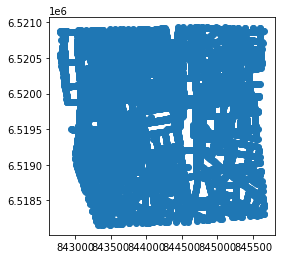

In [65]:
sensors.plot()

On utilise l'outil de calcul des zones des isovist de t4gpd sur les points issues des voiries

Les isovist sont calculé pour un rayon maximal arbitraire de 50 metres


In [66]:
"""
from t4gpd.isovist.STIsovistField2D import STIsovistField2D
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess

_, isov = STIsovistField2D(bat, sensors, nRays=100, rayLength=50.0).run()


isov.to_file('isov.shp', driver = 'ESRI Shapefile')
"""

"\nfrom t4gpd.isovist.STIsovistField2D import STIsovistField2D\nfrom t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess\n\n_, isov = STIsovistField2D(bat, sensors, nRays=100, rayLength=50.0).run()\n\n\nisov.to_file('isov.shp', driver = 'ESRI Shapefile')\n"

On recharge la couche isov calculée précédement

In [67]:
isov = gpd.read_file(r'produced_data/isov.shp', mask=mask).to_crs(epsg=2154)

C:\Users\theot\Miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


[]

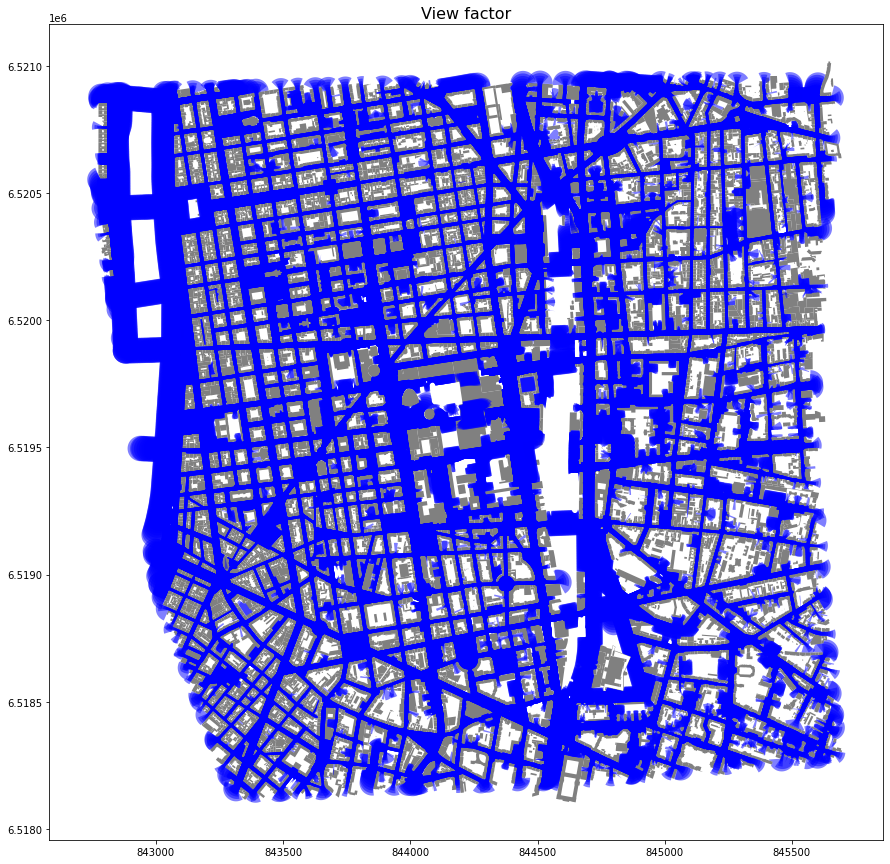

In [68]:
_, basemap = plt.subplots(figsize = (15,15 ))
basemap.set_title('View factor', fontsize=16)
bat.plot(ax=basemap, color='grey')
isov.plot(ax=basemap, color='blue', alpha=0.5)
plt.plot()

On observe les différentes zonnes considérées comme visibles, sans prendre un compte la topologie.
Comme on se place sur les voieries, l'espace d'étude est restrint à ce qui est visible depuis l'espace public uniquement

Il faut maintenant compter le nombre d'arbres pour chaque point de l'indicateur

In [69]:
arbres.geometry=arbres.geometry.centroid

In [70]:
from shapely.geometry import Point
arbres['point'] = arbres.geometry.apply(lambda p: p.centroid)
arbres = arbres.set_geometry('point')

On utilise join pour trouver tous les arbres intersectant chaque aire d'isovist 

In [71]:
test = gpd.sjoin(isov, arbres, how='left', op='intersects')

In [72]:
liste = {}
for i in range(len(test)):
    key = int(test['gid_left'][i:i+1])
    if (key in liste):
        liste[key]+=1
    else:
        liste[key]=1
        
l = []
for cle, i in liste.items():
    l.append(i)

On va ensuite tester et compter pour chaque sensor, le nombre d'arbres présent dans l'aire d'isovist


Ensuite, on définit notre indicateur, basé sur un facteur m, de toutes les valeurs de la table, afin de rester pertinent visuellement

Après des recherches avec plusieurs valeures différentes pour m, le nombre de 4 arbres a semblé être le plus pertinent

In [73]:
import pandas as pd

m = 4
s = pd.Series([k for k in l])

isov['tvf'] = s

In [74]:
isovmap = isov

In [75]:
isovmap.geometry = sensors.geometry

<AxesSubplot:title={'center':'Tree view factor'}>

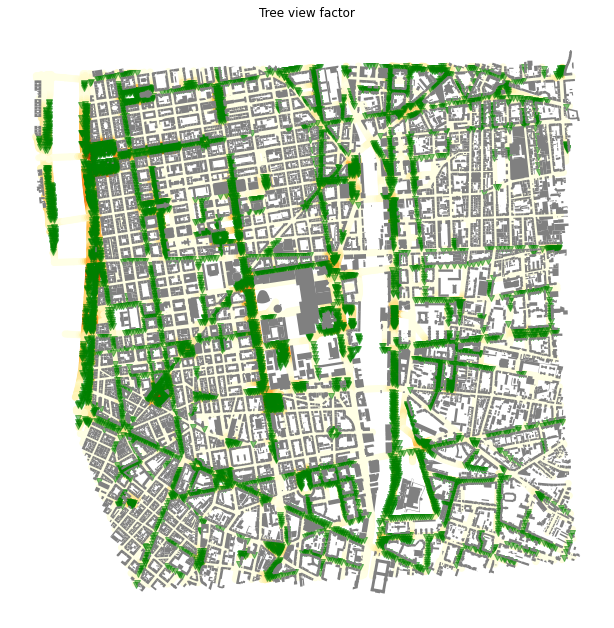

In [76]:
_,basemap = plt.subplots(figsize =(11, 11))
plt.axis('off')
plt.title('Tree view factor')
isovmap.plot(ax=basemap, cmap ='YlOrBr', column='tvf', linewidth=1)
arbres.plot(ax=basemap, marker='v',color = 'green', alpha=0.5)
bat.plot(ax=basemap, color='grey')

Réduction de l'aire afficher pour correspondre au périmètre d'étude

In [78]:
isovmap.to_file('produced_data/isovmap.shp', driver = 'ESRI Shapefile')

In [79]:
mask = gpd.read_file(r'data/zone.shp')
isovmap=gpd.read_file(r'produced_data/isovmap.shp', mask=mask)
bat = gpd.read_file(r"data\buildings.shp", mask=mask).to_crs(epsg=2154)
arbres = gpd.read_file('data/arbres_alignement_mask.shp', mask=mask).to_crs(epsg=2154)

C:\Users\theot\Miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:title={'center':'Tree view factor'}>

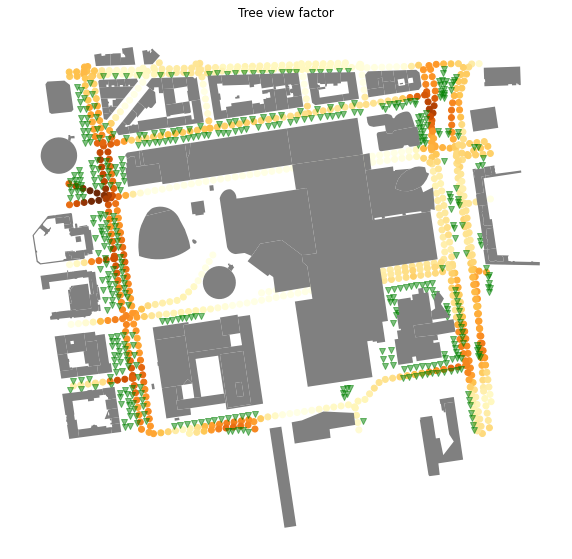

In [80]:
_,basemap = plt.subplots(figsize =(10, 10))
plt.axis('off')
plt.title('Tree view factor')
isovmap.plot(ax=basemap, cmap ='YlOrBr', column='tvf', linewidth=1)
arbres.plot(ax=basemap, marker='v', color = 'green', alpha=0.5)
bat.plot(ax=basemap, color='grey')